In [1]:
#Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa import arima
from statsmodels.graphics.tsaplots import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load data - US Macro Economic Data from 1959-Q1 to 2009-Q3

data = sm.datasets.macrodata.load_pandas().data

In [3]:
data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [4]:
#for explanation purpose we only take two variables - realgdp and realdpi

#realgdp - Real Gross Domestic Product: measure that reflects the value of all goods and services produced by an economy after adjusting for inflation

#realdpi - Real Disposable Personal Income: Net income left over after taxes and adjusted for inflation

In [5]:
df = data[['realgdp','realdpi']]
df.index = data['year']

In [6]:
df.head()

,realgdp,realdpi
year,,
1959.0,2710.349,1886.9
1959.0,2778.801,1919.7
1959.0,2775.488,1916.4
1959.0,2785.204,1931.3
1960.0,2847.699,1955.5


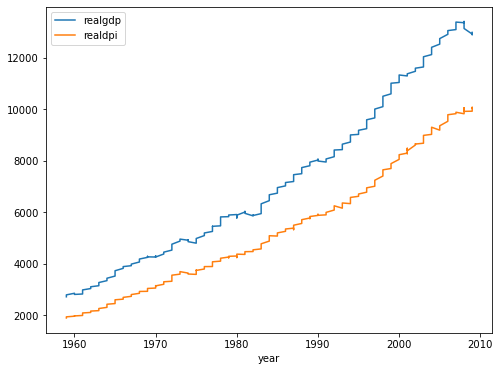

In [7]:
#Visualize the time series

df.plot(figsize=(8,6))
plt.show()

**ARIMA**

In [8]:
arima_df = df.copy()

In [9]:
arima_df.head()

,realgdp,realdpi
year,,
1959.0,2710.349,1886.9
1959.0,2778.801,1919.7
1959.0,2775.488,1916.4
1959.0,2785.204,1931.3
1960.0,2847.699,1955.5


**realgdp**

In [10]:
y = arima_df['realgdp']

In [11]:
# Stationarity Test
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.750463
p-value: 0.998246
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575


In [12]:
# difference once
arima_df["Diff_realgdp"] = arima_df["realgdp"].diff()
diff_values = arima_df["Diff_realgdp"].values
y_diff = diff_values[~np.isnan(diff_values)]
y = y_diff

In [13]:
# Stationarity Test
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.305696
p-value: 0.000000
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.575


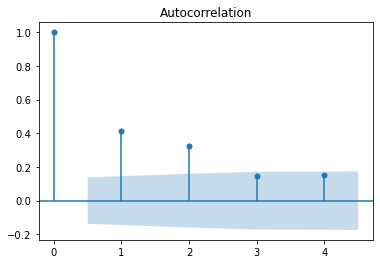

In [14]:
# plot acf, pacf
plot_acf(y, lags=4, alpha=0.05)
plt.show()

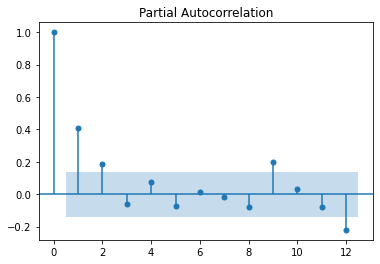

In [15]:
plot_pacf(y, lags=12, method='ols')
plt.show()

In [16]:
# train, test split
train = y[0:-12]
test = y[-12:]

In [17]:
# grid search and find best parameters
stepwise_fit = auto_arima(train, start_p = 0, 
                          start_q = 0,	max_p = 2, max_q = 2, 
                          m = 4, start_P = 0, max_P = 2,seasonal = True,
                          start_Q = 0, max_Q = 2,d = 1, D = 0, trace = True, 
                          error_action ='ignore', 
                          # we don't want to know if an order does not work 
                          suppress_warnings = True, 
                          # we don't want convergence warnings
                          information_criterion='aic',
                          stepwise = True)# set to stepwise 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=2103.941, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=2055.165, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=2035.777, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=2101.946, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=2033.895, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=2035.821, Time=0.23 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AIC=2035.366, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=2053.295, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept   : AIC=2037.252, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[4]             : AIC=2031.966, Time=0.07 sec
 ARIMA(0,1,1)(1,0,0)[4]             : AIC=2033.891, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[4]             : AIC=2033.847, Time=0.11 sec
 ARIMA(0,1,1)(1,0,1)[4]             : AIC=2

In [18]:
# To print the summary 
stepwise_fit.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  190
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 4)   Log Likelihood                -999.309
Date:                           Wed, 16 Feb 2022   AIC                           2016.618
Time:                                   18:29:05   BIC                           2045.793
Sample:                                        0   HQIC                          2028.437
                                           - 190                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4756      0.178     -2.667      0.008      -0.825      -0.126
ar.L2          0.3374      0.078      4.309      0.000       0.184       0.491
ma.L1         -0.2454      0.184     -1.336      0.182      -0.605       0.115
ma.L2         -0.6675      0.160     -4.161      0.000      -0.982      -0.353
ar.S.L4        0.6696      0.269      2.492      0.013       0.143       1.196
ar.S.L8       -0.5994      0.222     -2.698      0.007      -1.035      -0.164
ma.S.L4       -0.6874      0.306     -2.249      0.025      -1.286      -0.088
ma.S.L8        0.3886      0.261      1.489      0.136      -0.123       0.900
sigma2      2256.1902    201.755     11.183      0.000    1860.757    2651.623
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 8.83
Prob(Q):                              0.74   Prob(JB):                         0.01
Heteroskedasticity (H):               1.63   Skew:                             0.22
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
# use the efficient fit
model = arima.model.ARIMA(train, order=(2,1,2), seasonal_order=(2,0,2,4))
model_fitted = model.fit()
model_fitted.params
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                               y   No. Observations:                  190
Model:             ARIMA(2, 1, 2)x(2, 0, 2, 4)   Log Likelihood                -999.309
Date:                         Wed, 16 Feb 2022   AIC                           2016.618
Time:                                 18:29:10   BIC                           2045.793
Sample:                                      0   HQIC                          2028.437
                                         - 190                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4756      0.178     -2.667      0.008      -0.825      -0.126
ar.L2          0.3374      0.078      4.309      0.000       0.184       0.491
ma.L1         -0.2454      0.184     -1.336      0.182      -0.605       0.115
ma.L2         -0.6675      0.160     -4.161      0.000      -0.982      -0.353
ar.S.L4        0.6696      0.269      2.492      0.013       0.143       1.196
ar.S.L8       -0.5994      0.222     -2.698      0.007      -1.035      -0.164
ma.S.L4       -0.6874      0.306     -2.249      0.025      -1.286      -0.088
ma.S.L8        0.3886      0.261      1.489      0.136      -0.123       0.900
sigma2      2256.1902    201.755     11.183      0.000    1860.757    2651.623
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 8.83
Prob(Q):                              0.74   Prob(JB):                         0.01
Heteroskedasticity (H):               1.63   Skew:                             0.22
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

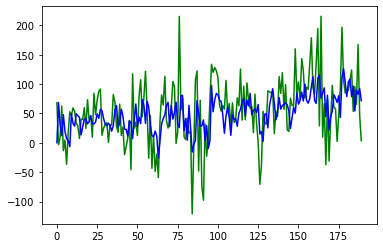

In [20]:
# plot train, test, in sample fitted values and out of sample forecast
plt.plot(train, color="g")
plt.plot(model_fitted.fittedvalues, color="b")

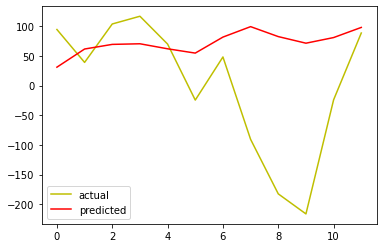

In [21]:
plt.plot(test, label = 'actual', color = 'y')
plt.plot(model_fitted.forecast(steps=len(test)), label = 'predicted', color="r")
plt.legend()
plt.show()

In [22]:
forecast = pd.DataFrame(model_fitted.forecast(steps=len(test)),
                        index = df.index[-12:],columns=['realgdp_Predicted_Differenced_1'])

In [23]:
#Transforming to Original Forecast
forecast["realgdp_Predicted"] = arima_df["realgdp"].iloc[-12-1] + forecast['realgdp_Predicted_Differenced_1'].cumsum()

In [24]:
forecast['realgdp_actual'] = arima_df.realgdp.iloc[-12:]

In [25]:
forecast

,realgdp_Predicted_Differenced_1,realgdp_Predicted,realgdp_actual
year,,,
2006.0,31.162479,12997.078479,13060.679
2007.0,61.814515,13058.892994,13099.901
2007.0,69.625718,13128.518712,13203.977
2007.0,70.667131,13199.185843,13321.109
2007.0,62.186461,13261.372304,13391.249
2008.0,54.935958,13316.308262,13366.865
2008.0,81.947321,13398.255582,13415.266
2008.0,99.584346,13497.839928,13324.600
2008.0,82.784605,13580.624533,13141.920


In [26]:
#rmse
mean_squared_error(forecast['realgdp_actual'],forecast['realgdp_Predicted'],squared=False)

427.8578307970079

**realdpi**

In [27]:
y = arima_df['realdpi']

In [28]:
# Stationarity Test
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.986025
p-value: 1.000000
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.575


In [29]:
# difference once
arima_df["Diff_realdpi"] = arima_df["realdpi"].diff()
diff_values = arima_df["Diff_realdpi"].values
y_diff = diff_values[~np.isnan(diff_values)]
y = y_diff

In [30]:
# Stationarity Test
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.864893
p-value: 0.000000
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.575


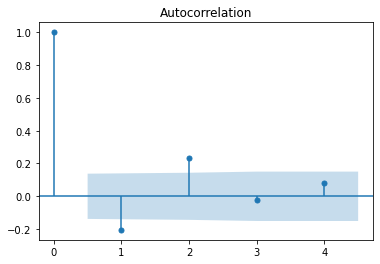

In [31]:
# plot acf, pacf
plot_acf(y, lags=4, alpha=0.05)
plt.show()

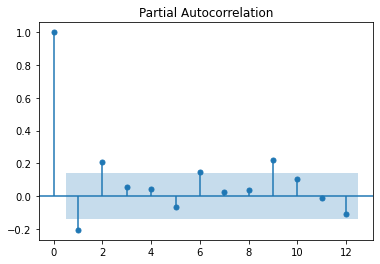

In [32]:
plot_pacf(y, lags=12, method='ols')
plt.show()

In [33]:
# train, test split
train = y[0:-12]
test = y[-12:]

In [34]:
# grid search and find best parameters
stepwise_fit = auto_arima(train, start_p = 0, 
                          start_q = 0,	max_p = 2, max_q = 2, 
                          m = 4, start_P = 0, max_P = 2,seasonal = True,
                          start_Q = 0, max_Q = 2,d = 1, D = 0, trace = True, 
                          error_action ='ignore', 
                          # we don't want to know if an order does not work 
                          suppress_warnings = True, 
                          # we don't want convergence warnings
                          information_criterion='aic',
                          stepwise = True)# set to stepwise 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=2144.707, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=2050.526, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=2142.707, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=2052.147, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[4] intercept   : AIC=2052.194, Time=0.27 sec
 ARIMA(1,1,0)(1,0,1)[4] intercept   : AIC=2045.888, Time=0.45 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=2050.025, Time=0.22 sec
 ARIMA(1,1,0)(2,0,1)[4] intercept   : AIC=2047.850, Time=0.61 sec
 ARIMA(1,1,0)(1,0,2)[4] intercept   : AIC=2047.861, Time=0.74 sec
 ARIMA(1,1,0)(0,0,2)[4] intercept   : AIC=2050.720, Time=0.28 sec
 ARIMA(1,1,0)(2,0,2)[4] intercept   : AIC=2043.522, Time=0.81 sec
 ARIMA(0,1,0)(2,0,2)[4] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(2,1,0)(2,0,2)[4] intercept   : AIC=inf, Time=1.70 sec
 ARIMA(1,1,1)(2,0,2)[4] intercept   : AIC=inf, T

In [35]:
# To print the summary 
stepwise_fit.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  190
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 4)   Log Likelihood                -983.831
Date:                           Wed, 16 Feb 2022   AIC                           1983.662
Time:                                   18:29:49   BIC                           2009.596
Sample:                                        0   HQIC                          1994.168
                                           - 190                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7666      0.142     -5.417      0.000      -1.044      -0.489
ma.L1         -0.3268      0.176     -1.852      0.064      -0.673       0.019
ma.L2         -0.5140      0.169     -3.046      0.002      -0.845      -0.183
ar.S.L4       -0.2435      0.209     -1.167      0.243      -0.652       0.165
ar.S.L8        0.6950      0.139      5.003      0.000       0.423       0.967
ma.S.L4        0.0236      0.212      0.111      0.911      -0.391       0.439
ma.S.L8       -0.7651      0.132     -5.783      0.000      -1.024      -0.506
sigma2      1901.3350    180.239     10.549      0.000    1548.073    2254.597
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):                21.08
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               3.63   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
# use the efficient fit
model = arima.model.ARIMA(train, order=(1,1,1), seasonal_order=(2,0,2,4))
model_fitted = model.fit()
model_fitted.params
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  190
Model:             ARIMA(1, 1, 1)x(2, 0, [1, 2], 4)   Log Likelihood                -985.154
Date:                              Wed, 16 Feb 2022   AIC                           1984.308
Time:                                      18:29:55   BIC                           2007.000
Sample:                                           0   HQIC                          1993.501
                                              - 190                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2674      0.060     -4.448      0.000      -0.385      -0.150
ma.L1         -0.8802      0.043    -20.659      0.000      -0.964      -0.797
ar.S.L4       -0.1750      0.167     -1.050      0.294      -0.502       0.152
ar.S.L8        0.7675      0.116      6.598      0.000       0.540       0.995
ma.S.L4       -0.0150      0.177     -0.085      0.933      -0.362       0.332
ma.S.L8       -0.8075      0.126     -6.430      0.000      -1.054      -0.561
sigma2      1925.6649    183.015     10.522      0.000    1566.963    2284.367
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.26
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               3.53   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

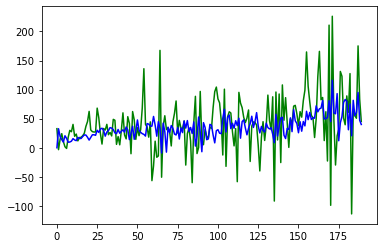

In [37]:
# plot train, test, in sample fitted values and out of sample forecast
plt.plot(train, color="g")
plt.plot(model_fitted.fittedvalues, color="b")

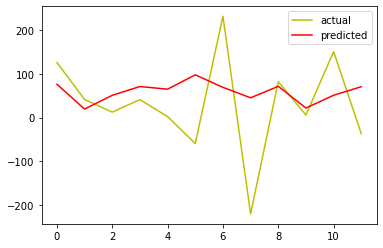

In [38]:
plt.plot(test, label = 'actual', color = 'y')
plt.plot(model_fitted.forecast(steps=len(test)), label = 'predicted', color="r")
plt.legend()
plt.show()

In [39]:
forecast = pd.DataFrame(model_fitted.forecast(steps=len(test)),
                        index = df.index[-12:],columns=['realdpi_Predicted_Differenced_1'])

In [40]:
#Transforming to Original Forecast
forecast["realdpi_Predicted"] = arima_df["realdpi"].iloc[-12-1] + forecast['realdpi_Predicted_Differenced_1'].cumsum()

In [41]:
forecast['realdpi_actual'] = arima_df.realdpi.iloc[-12:]

In [42]:
forecast

,realdpi_Predicted_Differenced_1,realdpi_Predicted,realdpi_actual
year,,,
2006.0,76.445011,9738.945011,9788.8
2007.0,19.488564,9758.433576,9830.2
2007.0,51.025883,9809.459458,9842.7
2007.0,71.210464,9880.669923,9883.9
2007.0,65.056994,9945.726917,9886.2
2008.0,97.967206,10043.694122,9826.8
2008.0,69.215375,10112.909498,10059.0
2008.0,45.311746,10158.221244,9838.3
2008.0,71.650060,10229.871304,9920.4


In [43]:
#rmse
mean_squared_error(forecast['realdpi_actual'],forecast['realdpi_Predicted'],squared=False)

209.74676488124

**VAR**

In [44]:
df.head()

,realgdp,realdpi
year,,
1959.0,2710.349,1886.9
1959.0,2778.801,1919.7
1959.0,2775.488,1916.4
1959.0,2785.204,1931.3
1960.0,2847.699,1955.5


In [45]:
#Granger Causality Tests - realdpi granger causes realgdp
result = grangercausalitytests(df,maxlag=12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0451  , p=0.8320  , df_denom=199, df_num=1
ssr based chi2 test:   chi2=0.0458  , p=0.8306  , df=1
likelihood ratio test: chi2=0.0458  , p=0.8306  , df=1
parameter F test:         F=0.0451  , p=0.8320  , df_denom=199, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8221  , p=0.0619  , df_denom=196, df_num=2
ssr based chi2 test:   chi2=5.7882  , p=0.0553  , df=2
likelihood ratio test: chi2=5.7064  , p=0.0577  , df=2
parameter F test:         F=2.8221  , p=0.0619  , df_denom=196, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1094  , p=0.0276  , df_denom=193, df_num=3
ssr based chi2 test:   chi2=9.6665  , p=0.0216  , df=3
likelihood ratio test: chi2=9.4402  , p=0.0240  , df=3
parameter F test:         F=3.1094  , p=0.0276  , df_denom=193, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0785  , p=0.0852  

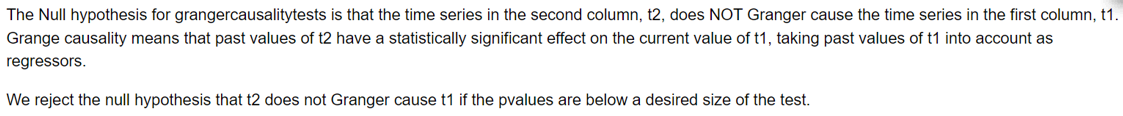

In [46]:
#reordering the dataframe
df = df[['realdpi','realgdp']]

In [47]:
df.head()

,realdpi,realgdp
year,,
1959.0,1886.9,2710.349
1959.0,1919.7,2778.801
1959.0,1916.4,2775.488
1959.0,1931.3,2785.204
1960.0,1955.5,2847.699


In [48]:
#Granger Causality Tests - realgdp granger causes realdpi
result = grangercausalitytests(df,maxlag=12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.6870 , p=0.0005  , df_denom=199, df_num=1
ssr based chi2 test:   chi2=12.8783 , p=0.0003  , df=1
likelihood ratio test: chi2=12.4844 , p=0.0004  , df=1
parameter F test:         F=12.6870 , p=0.0005  , df_denom=199, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.9020  , p=0.0013  , df_denom=196, df_num=2
ssr based chi2 test:   chi2=14.1562 , p=0.0008  , df=2
likelihood ratio test: chi2=13.6799 , p=0.0011  , df=2
parameter F test:         F=6.9020  , p=0.0013  , df_denom=196, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6719  , p=0.0132  , df_denom=193, df_num=3
ssr based chi2 test:   chi2=11.4152 , p=0.0097  , df=3
likelihood ratio test: chi2=11.1013 , p=0.0112  , df=3
parameter F test:         F=3.6719  , p=0.0132  , df_denom=193, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.5250  , p=0.0084  

In [49]:
#reordering the dataframe again
df = df[['realgdp','realdpi']]

In [50]:
# Stationarity Test for realgdp
result = adfuller(df['realgdp'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.750463
p-value: 0.998246
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575


In [51]:
# Stationarity Test for realdpi
result = adfuller(df['realdpi'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.986025
p-value: 1.000000
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.575


**The series is not stationary. Let us do differencing**

In [52]:
df_differenced = df.diff().dropna()

In [53]:
df_differenced.head()

,realgdp,realdpi
year,,
1959.0,68.452,32.8
1959.0,-3.313,-3.3
1959.0,9.716,14.9
1960.0,62.495,24.2
1960.0,-13.309,10.6


In [54]:
# Stationarity Test for realgdp
result = adfuller(df_differenced['realgdp'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.305696
p-value: 0.000000
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.575


In [55]:
# Stationarity Test for realdpi
result = adfuller(df_differenced['realdpi'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.864893
p-value: 0.000000
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.575


*Cointegration is a statistical property of a collection (X1, X2, ..., Xk) of time series variables. First, all of the series must be integrated(stationary) of order d. Next, if a linear combination of this collection is integrated(stationary) of order less than d, then the collection is said to be co-integrated.*

In [56]:
# Stationarity Test for realgdp+realdpi
result = adfuller(df_differenced['realgdp']+df_differenced['realdpi'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.503156
p-value: 0.000000
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.575


In [57]:
#cointegration test - the null hypothesis:
#no cointegration present between two time series(or no statistically significant relationship between two time series )
ts.coint(df_differenced['realgdp'],df_differenced['realdpi'])

(-3.761534312299772,
 0.01524230364913689,
 array([-3.95175692, -3.36669739, -3.06561782]))

**Series is now stationary**

In [58]:
#split series into train and test

#Last 10 observations are kept as test data

df_train, df_test = df_differenced.iloc[:-12,:], df_differenced.iloc[-12:,:]

In [59]:
print(df_train.shape)
print(df_test.shape)

(190, 2)
(12, 2)


In [60]:
df_train

,realgdp,realdpi
year,,
1959.0,68.452,32.8
1959.0,-3.313,-3.3
1959.0,9.716,14.9
1960.0,62.495,24.2
1960.0,-13.309,10.6
...,...,...
2005.0,95.618,55.0
2005.0,65.546,50.7
2006.0,167.239,175.1


In [61]:
df_test

,realgdp,realdpi
year,,
2006.0,94.763,126.3
2007.0,39.222,41.4
2007.0,104.076,12.5
2007.0,117.132,41.2
2007.0,70.140,2.3
2008.0,-24.384,-59.4
2008.0,48.401,232.2
2008.0,-90.666,-220.7
2008.0,-182.680,82.1


In [62]:
#Select order(p) of VAR Model

model = VAR(df_train)
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  15.336969508323353
BIC :  15.43988211197604
FPE :  4578925.133143401
HQIC:  15.37866187928133 

Lag Order = 2
AIC :  15.32860950190867
BIC :  15.500760670144304
FPE :  4540894.5829626145
HQIC:  15.39835867775664 

Lag Order = 3
AIC :  15.338027596372585
BIC :  15.579928776244051
FPE :  4584069.012736912
HQIC:  15.436046047660419 

Lag Order = 4
AIC :  15.36557119978433
BIC :  15.677740232724318
FPE :  4712468.680494434
HQIC:  15.492073978823235 

Lag Order = 5
AIC :  15.392525090879914
BIC :  15.775486324132473
FPE :  4841842.91157598
HQIC:  15.547729873977149 

Lag Order = 6
AIC :  15.412854759935701
BIC :  15.867139160467406
FPE :  4942226.068181004
HQIC:  15.596981890476474 

Lag Order = 7
AIC :  15.448605864908064
BIC :  15.974751135865674
FPE :  5123473.141708351
HQIC:  15.661878397303974 

Lag Order = 8
AIC :  15.464725803721423
BIC :  16.063276503505
FPE :  5208581.603960022
HQIC:  15.707369548245245 

Lag Order = 9
AIC :  15.471902655198237
BIC :  16.143410

**AIC drops to lowest at lag 2, then increases at lag 3**


**Let's go with lag 2 model**

In [63]:
#train the VAR model of selected order(p)

model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 16, Feb, 2022
Time:                     18:31:24
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    15.5008
Nobs:                     188.000    HQIC:                   15.3984
Log likelihood:          -1964.41    FPE:                4.54089e+06
AIC:                      15.3286    Det(Omega_mle):     4.30866e+06
--------------------------------------------------------------------
Results for equation realgdp
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             23.571824         6.126038            3.848           0.000
L1.realgdp         0.185142         0.078702            2.352           0.019
L1.realdpi         0.215710         0.086507            2.494         

In [64]:
#checking for correlation of errors using ljung-box test

sm.stats.acorr_ljungbox(model_fitted.resid['realgdp'], lags=2, return_df=True)

,lb_stat,lb_pvalue
1,0.000666,0.979413
2,0.011145,0.994443


In [65]:
sm.stats.acorr_ljungbox(model_fitted.resid['realdpi'], lags=2, return_df=True)

,lb_stat,lb_pvalue
1,0.025873,0.872211
2,0.489826,0.782772


**Errors are independently distributed(white noise)**

<AxesSubplot:xlabel='year'>

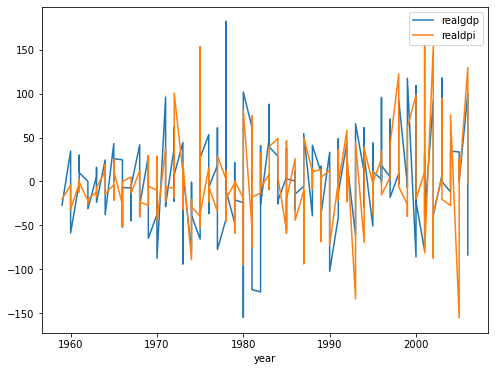

In [66]:
model_fitted.resid.plot(figsize=(8,6))

In [67]:
#Forecasting

df_train.values[-2:]

array([[46.524, 83.5  ],
       [ 3.454, 45.2  ]])

In [68]:
lagged_values = df_train.values[-2:]
forecast = pd.DataFrame(model_fitted.forecast(y=lagged_values, steps=12), index = df_test.index, 
                        columns = ['realgdp_1d', 'realdpi_1d'])
forecast

,realgdp_1d,realdpi_1d
year,,
2006.0,44.624911,29.749146
2007.0,39.503618,38.453598
2007.0,48.813624,36.528572
2007.0,49.159755,39.697515
2007.0,51.821051,39.535715
2008.0,52.388315,40.513234
2008.0,53.255812,40.603902
2008.0,53.565520,40.915201
2008.0,53.871513,40.989290


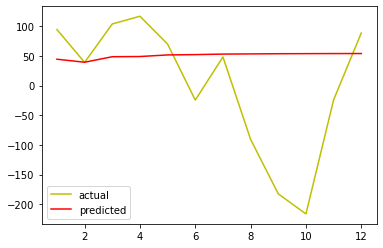

In [69]:
x = np.arange(1,13)
plt.plot(x,df_test['realgdp'], label = 'actual', color = 'y')
plt.plot(x,forecast['realgdp_1d'], label = 'predicted', color="r")
plt.legend()
plt.show()

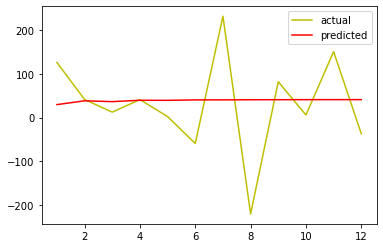

In [70]:
x = np.arange(1,13)
plt.plot(x,df_test['realdpi'], label = 'actual', color = 'y')
plt.plot(x,forecast['realdpi_1d'], label = 'predicted', color="r")
plt.legend()
plt.show()

In [71]:
#Transforming to Original Forecast

forecast["realgdp_forecasted"] = df["realgdp"].iloc[-12-1] + forecast['realgdp_1d'].cumsum()
forecast["realdpi_forecasted"] = df["realdpi"].iloc[-12-1] + forecast['realdpi_1d'].cumsum() 

forecast

,realgdp_1d,realdpi_1d,realgdp_forecasted,realdpi_forecasted
year,,,,
2006.0,44.624911,29.749146,13010.540911,9692.249146
2007.0,39.503618,38.453598,13050.044529,9730.702744
2007.0,48.813624,36.528572,13098.858153,9767.231316
2007.0,49.159755,39.697515,13148.017908,9806.928831
2007.0,51.821051,39.535715,13199.838959,9846.464546
2008.0,52.388315,40.513234,13252.227274,9886.977780
2008.0,53.255812,40.603902,13305.483086,9927.581682
2008.0,53.565520,40.915201,13359.048606,9968.496883
2008.0,53.871513,40.989290,13412.920119,10009.486173


In [72]:
#Actual vs Predicted - RealGDP
realgdp_pred = pd.DataFrame()
realgdp_pred['actual'] = df.iloc[-12:,0]
realgdp_pred['predicted'] = forecast['realgdp_forecasted']

In [73]:
realgdp_pred

,actual,predicted
year,,
2006.0,13060.679,13010.540911
2007.0,13099.901,13050.044529
2007.0,13203.977,13098.858153
2007.0,13321.109,13148.017908
2007.0,13391.249,13199.838959
2008.0,13366.865,13252.227274
2008.0,13415.266,13305.483086
2008.0,13324.600,13359.048606
2008.0,13141.920,13412.920119


In [74]:
#Performance metric
print('RMSE of realgdp: ',rmse(realgdp_pred['actual'],realgdp_pred['predicted']))

RMSE of realgdp:  316.44820205011126


In [75]:
#Actual vs Predicted - RealDPI
realdpi_pred = pd.DataFrame()
realdpi_pred['actual'] = df.iloc[-12:,1]
realdpi_pred['predicted'] = forecast['realdpi_forecasted']

In [76]:
realdpi_pred

,actual,predicted
year,,
2006.0,9788.8,9692.249146
2007.0,9830.2,9730.702744
2007.0,9842.7,9767.231316
2007.0,9883.9,9806.928831
2007.0,9886.2,9846.464546
2008.0,9826.8,9886.977780
2008.0,10059.0,9927.581682
2008.0,9838.3,9968.496883
2008.0,9920.4,10009.486173


In [77]:
#Performance metric
print('RMSE of realdpi: ',rmse(realdpi_pred['actual'],realdpi_pred['predicted']))

RMSE of realdpi:  92.34877649113082
